In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import geopy.distance
import networkx as nx
import numpy as np
import community.community_louvain
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.cm as cm
import collections
import seaborn as sns
import json

years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
#years = ['2019','2020','2021']
dataframes_OD = {}
dataframes_Stations = {}
'''!!!!!!!!!!!!!!!!!!!!!!!!!
    Filepath export on my local Machine, please comment it out and 
    unzip files in ../data on your machine.
    !!!!!!!!!!!!!!!!!!!!!!!
'''
filepath_export = "/content/drive/My Drive/COMP599/FinalProject/BIXI-Network-Analysis"

#Create trip and station dataframes for all wanted years
for yr in years:
    dataframes_OD[yr] = pd.read_csv("{}/data/BixiMontrealRentals{}/OD_{}.csv".format(filepath_export, yr, yr), low_memory=False)
    dataframes_Stations[yr] = pd.read_csv("{}/data/BixiMontrealRentals{}/Stations_{}.csv".format(filepath_export, yr, yr), low_memory=False)
#convert start_date and end_date to datetime objects
for k,v in dataframes_OD.items():
  dataframes_OD[k][['start_date','end_date']] = dataframes_OD[k][['start_date','end_date']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M')


In [ ]:
#Convert the start_station_code and end_station_code to int64 value types and 
#Only keep trips that started from stations that correspond to existing stations(defined by station code) each year
for k,v in dataframes_OD.items():
  temp=v.copy()
  temp['start_station_code']=pd.to_numeric(temp['start_station_code'], errors='coerce')
  temp['end_station_code']=pd.to_numeric(temp['end_station_code'], errors='coerce')
  temp.dropna(inplace=True)
  temp['start_station_code']=temp['start_station_code'].astype(np.int64)
  temp['end_station_code']=temp['end_station_code'].astype(np.int64)
  #Only keep trips that started from stations that correspond to existing stations(defined by code) each year
  temp_OD=temp.copy()
  temp_Stations=dataframes_Stations[k].copy()
  dataframes_OD[k] = temp_OD[temp_OD['start_station_code'].isin(temp_Stations['code']) & temp_OD['end_station_code'].isin(temp_Stations['code'])].reset_index(drop=True)

In [ ]:
#Concatenate cleaned dataframes
df_concat_OD = pd.concat(list(dataframes_OD.values()), ignore_index=True, sort=False)
df_concat_Stations = pd.concat(list(dataframes_Stations.values()), ignore_index=True, sort=False)

In [ ]:
#count the number of stations over time
df=df_concat_Stations.copy()
print(df.groupby('year')['code'].agg('count'))
#print("Num. Stations in 2021: ", dataframes_Stations['2021']['code'].nunique())

year
2014    459
2015    460
2016    465
2017    546
2018    552
2019    619
2020    641
2021    823
Name: code, dtype: int64


In [ ]:
#Visualize the daily trips over time
def plot_yearly_trips(data):    
    df = data.copy()
    global yearly_df
    yearly_df = df.groupby(df['start_date'].dt.date).size().reset_index(name='count')
    #Initialize a figure and plot on the canvas
    fig, ax = plt.subplots(figsize=(20,11))
    ax.set_title("Number of Montreal BIXI trips over time", fontsize= 30)
    ax.set_ylabel("Number of Montreal BIXI trips", fontsize= 20)
    ax.set_xlabel("Years", fontsize= 20)
    plt.plot(yearly_df['start_date'], yearly_df["count"], color= 'c')
    plt.grid(linestyle=":")
    #Save plot first
    fig.savefig("{}/plots/trips_over_time.png".format(filepath_export), format="png")
    plt.show()
plot_yearly_trips(df_concat_OD)    

In [ ]:
def add_weather_data(data):
    years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
    OD_with_weather = {}
    #Get the weather and combine it with the dataframe_OD
    for yr in years:
        weather = pd.read_csv("{}/data/BixiMontrealRentals{}/weather_{}.csv".format(filepath_export, yr, yr), low_memory=False)
        weather.rename(columns={"Date/Time (LST)":"start_date", "Temp (°C)":"temp", "Precip. Amount (mm)":"precipitation"}, inplace=True)

        weather["start_date"] = weather["start_date"].apply(pd.to_datetime, format='%Y-%m-%d %H:%M')
        weather.sort_values(by=['start_date'], inplace = True)

        df = data[yr].copy()
        df.sort_values(by=['start_date'], inplace = True)

        OD_with_weather[yr] = pd.merge_asof(df, weather, on="start_date", direction="nearest")

    return OD_with_weather 
    

In [ ]:
df = add_weather_data(df_concat_OD, 2020)
df.dropna(inplace=True)
df["temp"] = df["temp"].astype(int)
#df.set_index('start_date').between_time('12:00:00', '15:00:00').reset_index()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,temp,precipitation
0,2020-04-15 12:00:21,6134,2020-04-15 12:14:04,7037,822,1,3,0.0
1,2020-04-15 12:00:34,7098,2020-04-15 12:29:36,7098,1742,1,3,0.0
2,2020-04-15 12:00:43,6155,2020-04-15 12:09:22,6139,518,1,3,0.0
3,2020-04-15 12:00:57,6155,2020-04-15 12:09:28,6139,511,1,3,0.0
4,2020-04-15 12:02:14,6362,2020-04-15 12:08:13,6022,358,1,3,0.0
...,...,...,...,...,...,...,...,...
556162,2020-11-15 14:58:57,6306,2020-11-15 15:28:12,6112,1754,1,4,0.0
556163,2020-11-15 14:59:08,6370,2020-11-15 15:01:49,6368,160,1,4,0.0
556164,2020-11-15 14:59:21,7017,2020-11-15 15:05:12,6394,350,1,4,0.0
556165,2020-11-15 14:59:25,6261,2020-11-15 15:10:11,6187,645,0,4,0.0


In [ ]:
def trips_temperaturePlot(data):
    
    OD_with_weather = add_weather_data(data)
    df = pd.concat(list(OD_with_weather.values()), ignore_index=True, sort=False)
    df.dropna(inplace=True)
    df["temp"] = df["temp"].astype(int)
    fig, ax = plt.subplots(figsize=(20,11))
    ax = sns.countplot(x="temp",data=df, color = 'c')

    ax.set_xlabel("Temparature °C", fontsize= 20, x = 0.5)
    ax.set_ylabel("Number of Rides", fontsize= 20)
    ax.set_title(f"Number of Montreal BIXI rides vs Temperature", fontsize= 30)
    plt.ticklabel_format(style='plain', axis='y')

    ax.grid(linestyle=":")
    #Save plot first
    fig.savefig("{}/plots/rides_vs_temperature_overall.png".format(filepath_export), format="png")
    plt.show()

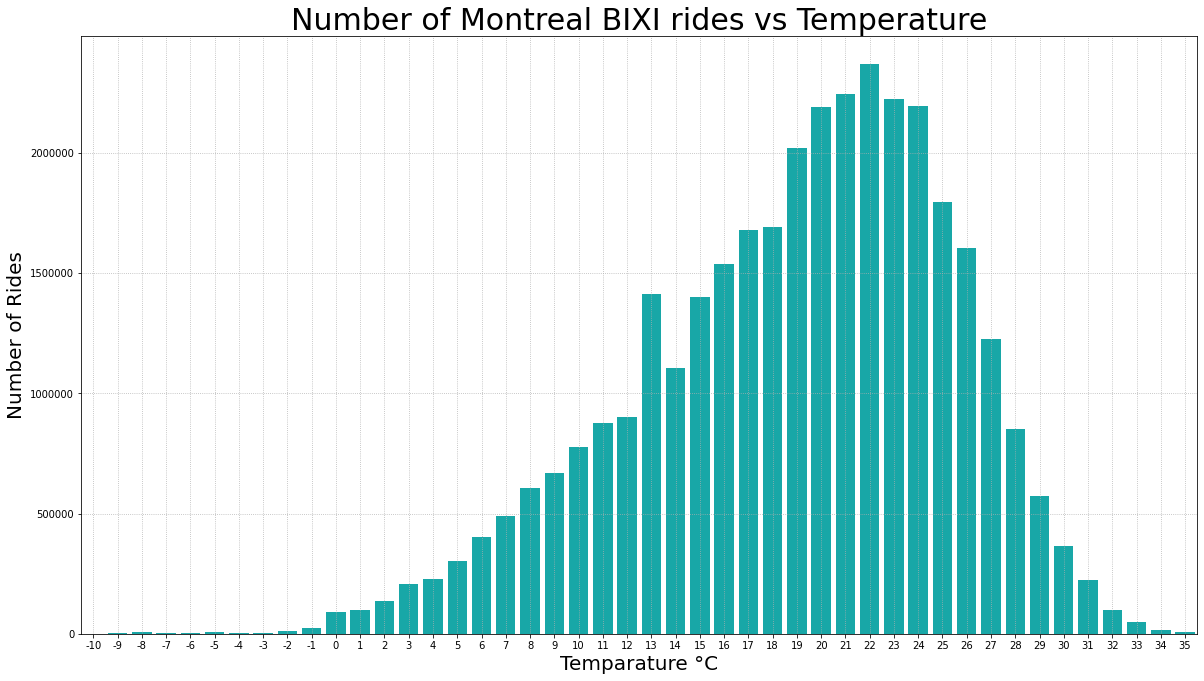

In [ ]:
trips_temperaturePlot(dataframes_OD)

In [ ]:
trips_temperaturePlot(df_concat_OD, 2020)

In [ ]:
trips_temperaturePlot(df_concat_OD, 2021)

In [ ]:
def weekly_usage(data, year):
  df = data.copy()
  df = df[df['start_date'].dt.year == year]
  df["hour"] = df['start_date'].dt.hour
  df["day"] = df['start_date'].dt.strftime("%A")
  daily_usage = df.groupby(by=['day','hour']).count()['start_date'].unstack()
  daily_usage = daily_usage.reindex(["Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
  fig, ax = plt.subplots(figsize=(20,11))
  sns.heatmap(daily_usage, cmap="Reds", yticklabels=list(daily_usage.index))
  plt.title(f"Weekly Temporal BIXI Usage For Year {year}", fontsize= 30)
  plt.ylabel("Day of the week", fontsize= 20)
  plt.xlabel("Time(Hours)", fontsize= 20)
  #Save plot first
  fig.savefig("{}/plots/weekly_usage-{}.png".format(filepath_export, year), format="png")
  plt.show()

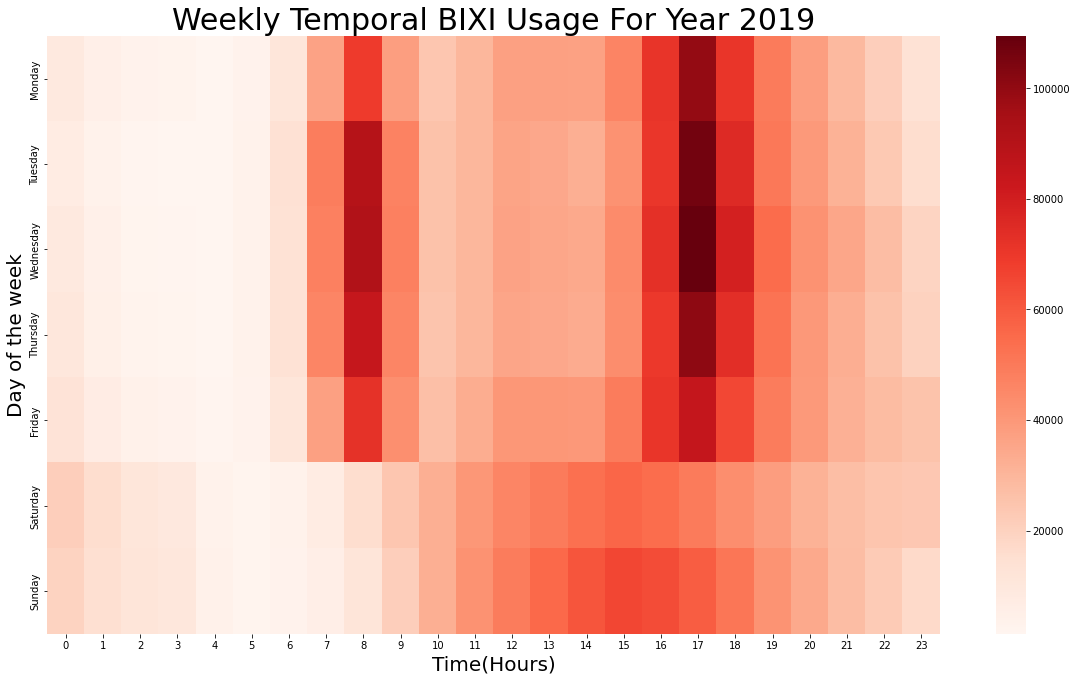

In [ ]:
weekly_usage(df_concat_OD, 2019)

In [ ]:
weekly_usage(df_concat_OD, 2020)

In [ ]:
weekly_usage(df_concat_OD, 2021)

In [ ]:
def cacheGraph(G, year, name):
    name = name + '_' + str(year)
    nx.write_gml(G, "{}/data/BixiMontrealRentals{}/CachedGraphs/{}.gml".format(filepath_export, year, name))

def loadCachedGraph(year, name):
    name = name + '_' + str(year)
    return nx.read_gml("{}/data/BixiMontrealRentals{}/CachedGraphs/{}.gml".format(filepath_export, year, name), destringizer=int)

In [ ]:
def get_simple_directed_graph(G):
    G = G.copy()
    DG = nx.DiGraph()
    DG.update(nodes=G.nodes(data=True)) 
    for a,b,data in G.edges(data=True):
        #Initialize weight
        w = data['weight'] if 'weight' in data else 1.0
        #Inialize average duration
        duration_avg = np.mean([v for elt in G.get_edge_data(a,b).values() for k,v in elt.items()])
        if DG.has_edge(a,b):
            DG[a][b]['weight'] += w
        else:
            DG.add_edge(a, b, weight=w, duration_sec=duration_avg, distance=data['distance'])
    
    return DG

In [ ]:
def create_graph(data_OD, data_Stations, year, loadCached=False, cache=True, simple_directed_graph=True, name='DiGraph', get_df_only=False):
    
    df_stations = data_Stations.copy()  
    df_stations = df_stations[df_stations['year'] == year]
    
    stations_names={k:v for k,v in list(zip(list(df_stations['code']), 
                                       list(df_stations['name'])))}
    #If requested, return the cached Graph
    if loadCached == True:
      try:
          return loadCachedGraph(year, name), stations_names
      except:
          print('ERROR: Unable to load cache')

    df = data_OD.copy()
    df = df[df['start_date'].dt.year == year]
    
    stations_coord={k:list(v) for k,v in list(zip(list(df_stations['code']), 
                                                  list(df_stations[['latitude','longitude']].to_records(index=False))))}
    
    #Get the latitude and longitude of trips start_date and end date
    df_start = df[['start_station_code']].copy()
    df_start=df_start.rename({'start_station_code':'code'}, axis=1).drop_duplicates(subset=['code'])
    df_start=df_start.merge(df_stations[['code','latitude','longitude']].copy(), on='code')
    df_start.rename({'code':'start_station_code','latitude':'start_latitude','longitude':'start_longitude'}, axis=1, inplace=True)
    df=df.merge(df_start, on='start_station_code')

    df_end = df[['end_station_code']].copy()
    df_end=df_end.rename({'end_station_code':'code'}, axis=1).drop_duplicates(subset=['code'])
    df_end=df_end.merge(df_stations[['code','latitude','longitude']].copy(), on='code')
    df_end.rename({'code':'end_station_code','latitude':'end_latitude','longitude':'end_longitude'}, axis=1, inplace=True)
    df=df.merge(df_end, on='end_station_code')

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # If you only want to get the dataframe with added info and not the graph
    if get_df_only == True:
      return df

    #Get the distance between trip start and end in meters
    for i in list(df.index):
        start = (df.at[i,'start_latitude'], df.at[i,'start_longitude'])
        end = (df.at[i,'end_latitude'], df.at[i,'end_longitude'])
        df.at[i,'distance']=geopy.distance.geodesic(start, end).m
    
    df.dropna(inplace=True)

    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'start_station_code', 'end_station_code', edge_attr=['duration_sec','distance'], create_using=nx.MultiDiGraph())
    #Add stations coordinates to each node
    for k, v in stations_coord.items():
      if k in G: # Check if station in graph (needed when using subgraphs with smaller timeframe)
        G.nodes[k]['coord'] = v
    #Remove self loop edges
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    
    if simple_directed_graph == True:
        #Convert the Graph to simple Directed Graph
        G = get_simple_directed_graph(G)

    #Cache Graph
    if cache == True:
        cacheGraph(G, year, name)

    return G, stations_names

In [ ]:
def centrality_measures(G, stations_names, yr, top_n=3):

    #Print the Graph general info.
    print("BIXI Montreal Network Description: \n",nx.info(G))
    print("Network density: {}\n".format(nx.density(G)))
    
    ###Compute the degree centrality
    degree_centr=dict(G.degree(G.nodes(), weight='weight'))
    degree_centr=dict(sorted(degree_centr.items(), key=lambda x: x[1], reverse=True))
    top5_degree={stations_names[k]:v for k,v in list(degree_centr.items())[:top_n]}
    
    print("Top {} nodes by degree centrality ({}):\n".format(top_n,yr))
    for item in top5_degree.items():
        print(item)
    #Plot Network
    #plot_centrality(G, degree_centr, 'Degree')
    #Export centrality measure values
    #export_centrality_values(G, degree_centr, stations_names, 'Degree', yr)


    ###Compute the eigenvalue centrality
    eigen_centr = nx.eigenvector_centrality(G, weight='weight')
    eigen_centr=dict(sorted(eigen_centr.items(), key=lambda x: x[1], reverse=True))
    top5_eigenvector={stations_names[k]:v for k,v in list(eigen_centr.items())[:top_n]}

    print("\nTop {} nodes by eigenvector centrality ({}):\n".format(top_n,yr))
    for item in top5_eigenvector.items():
        print(item)
    #Plot Network
    #plot_centrality(G, eigen_centr, 'Eigenvector')
    #Export centrality measure values
    #export_centrality_values(G, eigen_centr, stations_names, 'Eigenvector', yr)


    ###Compute the betweenness centrality
    print('Changes weights to reciprocal for betweenness centrality, as weight is interpreted as distance but here we want to maintain connection strength')
    BG = G.copy()
    for u,v,w in BG.edges(data=True):
      w['weight'] = 1/w['weight']

    betweenness_centr = nx.betweenness_centrality(BG, weight='weight', normalized=False)
    betweenness_centr = dict(sorted(betweenness_centr.items(), key=lambda x: x[1], reverse=True))
    top5_betweenness={stations_names[k]:v for k,v in list(betweenness_centr.items())[:top_n]}

    print("\nTop {} nodes by betweeness centrality ({}):\n".format(top_n, yr))
    for item in top5_betweenness.items():
        print(item)
    #Plot Network
    #plot_centrality(BG, betweenness_centr, 'Betweenness')
    #Export centrality measure values
    export_centrality_values(BG, betweenness_centr, stations_names, 'Betweenness_reciprocal', yr)
    


In [ ]:
def plot_centrality(G, data, measure):

    fig, ax = plt.subplots(figsize=(30,18))
    #Initialize node color
    colors=range(20)
    node_color = list(data.values())
    cmap=plt.cm.viridis
    vmin = min(node_color)
    if measure == 'Betweenness':
      vmax = max(node_color) - (sum(node_color)/len(node_color))
    else:
      vmax = max(node_color)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))

    sm._A = []
    plt.colorbar(sm)
    #Plot Network
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('coord') ,node_color=node_color,cmap="viridis", node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('coord') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    ax.set_title(f"Montreal BIXI Network {measure} Centrality", fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    plt.show()

In [ ]:
def export_centrality_values(G, centrality_data, stations_names, centrality, yr):

    centr_augmented = {}
    for k,v in centrality_data.items():
        centr_augmented[k] = [v, stations_names[k], G.nodes[k]['coord'][0], G.nodes[k]['coord'][1]]

    with open(f"{filepath_export}/data/BixiMontrealRentals{yr}/{centrality}_centrality.csv", 'w') as csv_file:  
        writer = csv.writer(csv_file)
        writer.writerow(['station_code', 'degree', 'station_name', 'lat', 'lon'])
        for key, value in centr_augmented.items():
            writer.writerow([key, value[0], value[1], value[2], value[3]])

In [ ]:
SDG19, stations_names19 = create_graph(df_concat_OD, df_concat_Stations, 2019, loadCached=True)

In [ ]:
centrality_measures(SDG19, stations_names19, 2019)

BIXI Montreal Network Description: 
 DiGraph with 619 nodes and 221903 edges
Network density: 0.5800748675962378

Top 3 nodes by degree centrality (2019):

('de la Commune / King', 84355.0)
('Métro Laurier (Rivard / Laurier)', 83476.0)
('Métro Mont-Royal (Rivard / du Mont-Royal)', 82594.0)

Top 3 nodes by eigenvector centrality (2019):

('de la Commune / King', 0.23057081412908087)
('de la Commune / Place Jacques-Cartier', 0.20479862200106513)
('de la Commune / St-Sulpice', 0.19159313081380305)
Changes weights to reciprocal for betweenness centrality, as weight is interpreted as distance but here we want to maintain connection strength

Top 3 nodes by betweeness centrality (2019):

('de la Commune / King', 93372.0)
('BAnQ (Berri / de Maisonneuve)', 80996.0)
('Métro Mont-Royal (Rivard / du Mont-Royal)', 66069.0)


In [ ]:
SDG20, stations_names20 = create_graph(df_concat_OD, df_concat_Stations, 2020, loadCached=True)

In [ ]:
centrality_measures(SDG20, stations_names20, 2020)

BIXI Montreal Network Description: 
 DiGraph with 641 nodes and 219616 edges
Network density: 0.5353354134165367

Top 3 nodes by degree centrality (2020):

('Laurier / de Brébeuf', 42340.0)
('Métro Mont-Royal (Rivard / du Mont-Royal)', 39957.0)
('de la Commune / Place Jacques-Cartier', 38968.0)

Top 3 nodes by eigenvector centrality (2020):

('de la Commune / Place Jacques-Cartier', 0.18417443172229078)
('de la Commune / St-Sulpice', 0.1705719882755711)
('Marché Atwater', 0.16273757657088952)
Changes weights to reciprocal for betweenness centrality, as weight is interpreted as distance but here we want to maintain connection strength

Top 3 nodes by betweeness centrality (2020):

('Marché Atwater', 70370.0)
('Métro Papineau (Cartier / Ste-Catherine)', 58188.0)
('de la Commune / Place Jacques-Cartier', 51489.0)


NameError: ignored

In [ ]:
SDG20bis = SDG20.copy()

In [ ]:
eee = SDG20.edges()
print(SDG20.nodes)
print(eee[6212, 6001])
eee[6212, 6001]['weight'] = 7.0
print(eee[6212, 6001])
print(eee[6001, 6212])
eeee = SDG20bis.edges()
print(eeee[6212, 6001])
print(eeee[6001, 6212])

[6212, 6250, 6207, 6202, 6159, 7025, 6929, 6175, 6916, 6187, 6926, 6362, 6199, 6112, 6335, 6208, 6078, 6266, 7029, 6746, 6181, 6414, 6193, 6182, 6910, 6923, 6084, 6734, 6183, 6912, 6033, 6381, 6002, 6126, 6162, 6039, 6249, 6237, 6170, 6209, 6097, 6201, 6177, 7042, 6264, 6383, 6080, 6364, 6224, 6174, 6154, 6305, 6275, 6163, 6355, 6213, 6280, 6306, 6267, 6332, 6334, 6196, 6232, 6164, 6151, 6140, 6220, 6903, 6211, 7036, 6021, 6192, 6044, 6217, 6184, 6233, 6361, 6148, 6023, 6398, 6354, 6927, 6236, 6328, 6157, 6219, 6395, 6733, 6907, 6241, 6137, 7099, 6167, 6230, 6015, 6131, 6372, 6924, 6165, 6225, 6150, 7050, 6329, 6376, 6132, 6161, 6358, 6229, 6195, 6104, 7063, 6152, 6082, 7102, 6145, 6188, 6114, 6079, 6194, 7072, 6261, 6406, 7006, 6387, 6277, 6133, 6750, 6070, 6420, 6130, 7004, 6065, 6124, 6186, 6272, 6307, 6178, 6360, 6336, 7077, 6206, 6901, 6001, 6042, 6345, 6736, 6119, 6022, 6020, 6273, 6265, 6729, 7014, 6102, 6321, 6343, 7031, 7091, 6176, 6385, 6012, 6141, 7038, 6085, 6327, 6036, 614

In [ ]:
centrality_measures(SDG20, stations_names20, 2020)

BIXI Montreal Network Description: 
 DiGraph with 641 nodes and 219616 edges
Network density: 0.5353354134165367

Top 3 nodes by degree centrality (2020):

('Laurier / de Brébeuf', 42340.0)
('Métro Mont-Royal (Rivard / du Mont-Royal)', 39957.0)
('de la Commune / Place Jacques-Cartier', 38968.0)

Top 3 nodes by eigenvector centrality (2020):

('de la Commune / Place Jacques-Cartier', 0.18417443172229078)
('de la Commune / St-Sulpice', 0.1705719882755711)
('Marché Atwater', 0.16273757657088952)
Changes weights to reciprocal for betweenness centrality, as weight is interpreted as distance but here we want to maintain connection strength

Top 3 nodes by betweeness centrality (2020):

('Marché Atwater', 0.1720706181533646)
('Métro Papineau (Cartier / Ste-Catherine)', 0.14228286384976524)
('de la Commune / Place Jacques-Cartier', 0.12590228873239437)


In [ ]:
SDG21, stations_names21 = create_graph(df_concat_OD, df_concat_Stations, 2021, loadCached=True)
centrality_measures(SDG21, stations_names21, 2021)

BIXI Montreal Network Description: 
 DiGraph with 823 nodes and 309995 edges
Network density: 0.4582294909431698

Top 3 nodes by degree centrality (2021):

('Métro Mont-Royal (Rivard / du Mont-Royal)', 87102.0)
('Marquette / du Mont-Royal', 66265.0)
('du Mont-Royal / Clark', 62235.0)

Top 3 nodes by eigenvector centrality (2021):

('Métro Mont-Royal (Rivard / du Mont-Royal)', 0.22302825953044997)
('Marquette / du Mont-Royal', 0.1695420602489597)
('Boyer / du Mont-Royal', 0.14731447784996338)
Changes weights to reciprocal for betweenness centrality, as weight is interpreted as distance but here we want to maintain connection strength

Top 3 nodes by betweeness centrality (2021):

('Métro Mont-Royal (Rivard / du Mont-Royal)', 0.3462900563374438)
('du Mont-Royal / Clark', 0.21558777942749777)
('de la Commune / Place Jacques-Cartier', 0.20191905900761933)


In [ ]:
list(SDG21.nodes(data=True))[-5:]

[(1119, {'coord': [45.43982379999999, -73.6948782]}),
 (969, {'coord': [45.47188010000001, -73.53797970000002]}),
 (991, {'coord': [45.5002783, -73.5598773]}),
 (977, {'coord': [45.5039817, -73.6228395]}),
 (1021, {'coord': [45.6096263, -73.522739]})]

In [ ]:
def get_qc_curfew_data(data):

    df_OD21 = data.copy()
    mask = (df_OD21['start_date'].dt.date >= pd.to_datetime('2021-01-09').date()) & (df_OD21['start_date'].dt.date <= pd.to_datetime('2021-05-28').date())

    return df_OD21.loc[mask]


In [ ]:
#Return all data between 2 sepcified times for given year and days (0=Monday, 6=Sunday) 
#Note: Doesn't return last week of data if not complete, but not a problem as used as average data
def select_df_timeframe(data, year, start_time, end_time, days, is_curfew_dataset):

    df = data.copy()  
    df = df[df['start_date'].dt.year == year]
    if is_curfew_dataset == True:
        df = get_qc_curfew_data(df)

    df = df.set_index('start_date').between_time(start_time, end_time)
  
    week_OD = {}
    for i in days:
      week_OD[i] = df[df.index.weekday==i]

    week_OD_concat = pd.concat(list(week_OD.values()), ignore_index=False, sort=False)

    week_OD_concat = week_OD_concat.reset_index()

  
    return week_OD_concat

In [ ]:
#Creates a 24h dictionary with hourly grouped trips, at specified year and for specific days (0=Monday, 6=Sunday)
def get_OD_hourly(yr, days, is_curfew_dataset = False):
    OD_hourly = {}
    for hour in range(9):
        OD_hourly[hour] = select_df_timeframe(df_concat_OD, yr, '0'+str(hour)+':00:00', '0'+str(hour+1)+':00:00', days, is_curfew_dataset)
    for hour in range(9, 23):
        OD_hourly[hour] = select_df_timeframe(df_concat_OD, yr, str(hour)+':00:00', str(hour+1)+':00:00', days, is_curfew_dataset)
    OD_hourly[23] = select_df_timeframe(df_concat_OD, yr, '23:00:00', '23:59:59', days, is_curfew_dataset)
    return OD_hourly

#Creates a 24h dictionary with hourly grouped graphs, given a 24h dictionary with hourly grouped trips
def get_graph_hourly(OD_hourly, stations, yr, subname, loadCached = False):
    graph_hourly = {}
    for hour in range(24):
        G_hour = create_graph(OD_hourly[hour], stations, yr, loadCached=loadCached, name=(subname+str(hour)))[0]
        graph_hourly[hour] = G_hour

    return graph_hourly

In [ ]:
#Create a 24h dictionary with hourly grouped graphs
OD_hourly_19 = get_OD_hourly(2019, [0,1,2,3,4])
#print(OD_hourly_19)
graph_hourly19 = get_graph_hourly(OD_hourly_19, df_concat_Stations, 2019, '24h_graph_', loadCached = True)

In [ ]:
OD_hourly_20 = get_OD_hourly(2020, [0,1,2,3,4])
#print(OD_hourly_20)
graph_hourly20 = get_graph_hourly(OD_hourly_20, df_concat_Stations, 2020, '24h_graph_', loadCached = True)

In [ ]:
OD_hourly_21 = get_OD_hourly(2021, [0,1,2,3,4])
graph_hourly21 = get_graph_hourly(OD_hourly_21, df_concat_Stations, 2021, '24h_graph_', loadCached = True)

In [ ]:
OD_hourly_21_curfew = get_OD_hourly(2021, [0,1,2,3,4], is_curfew_dataset=True)
graph_hourly21_curfew = get_graph_hourly(OD_hourly_21_curfew, df_concat_Stations, 2021, '24h_graph_curfew')

In [ ]:
#Creates a net degree centrality dictionary, with net=indegree-outdegree
def net_degree_centrality_measure(G, stations_names, yr, name):
    in_degree_centr = dict(G.in_degree(G.nodes(), weight='weight'))
    out_degree_centr = dict(G.out_degree(G.nodes(), weight='weight'))
    
    net_degree_centr = {}
    for station in in_degree_centr:
        net = in_degree_centr[station] - out_degree_centr[station]
        if net > 0:
            net_degree_centr[station] = [net, 'in']
        else:
            net_degree_centr[station] = [-net, 'out']

    return net_degree_centr

In [ ]:
#Exports hourly/timeframe centrality_data in one csv file
def export_timeframe_centrality_values(Gs, centrality_datas, stations_names, centrality_name, yr, time):

    with open(f"{filepath_export}/data/BixiMontrealRentals{yr}/{centrality_name}_centrality.csv", 'w') as csv_file:  
        writer = csv.writer(csv_file)
        writer.writerow(['station_code', 'degree', 'direction', 'station_name', 'lat', 'lon', 'time'])
        
        for h in range(len(time)):
            hour_data = centrality_datas[h]
            G = Gs[h]
            for station_code, degree in hour_data.items():
                intensity = degree[0]
                direction = degree[1]
                writer.writerow([station_code, intensity, direction, stations_names[station_code], G.nodes[station_code]['coord'][0], G.nodes[station_code]['coord'][1], time[h]])                

In [ ]:
#Create hourly net degree centrality dictionary
def net_degree_hourly(graph_hourly, stations_names, yr):
    hourly_net_degree = {}
    for h, G in graph_hourly.items():
        hourly_net_degree[h] = net_degree_centrality_measure(G, stations_names, yr, str(h) + 'h_commute')
    return hourly_net_degree

In [ ]:
#Create and export hourly net degree centrality dictionary
net_degree_hourly19 = net_degree_hourly(graph_hourly19, stations_names19, 2019)
export_timeframe_centrality_values(graph_hourly19, net_degree_hourly19, stations_names19, 'allday_netDegree', 2019, [str(i)+':00:00' for i in range(24)])

In [ ]:
net_degree_hourly20 = net_degree_hourly(graph_hourly20, stations_names20, 2020)
export_timeframe_centrality_values(graph_hourly20, net_degree_hourly20, stations_names20, 'allday_netDegree', 2020, [str(i)+':00:00' for i in range(24)])

In [ ]:
net_degree_hourly21 = net_degree_hourly(graph_hourly21, stations_names21, 2021)
export_timeframe_centrality_values(graph_hourly21, net_degree_hourly21, stations_names21, 'allday_netDegree', 2021, [str(i)+':00:00' for i in range(24)])

In [ ]:
net_degree_hourly21_curfew = net_degree_hourly(graph_hourly21_curfew, stations_names21, 2021)
export_timeframe_centrality_values(graph_hourly21_curfew, net_degree_hourly21_curfew, stations_names21, 'allday_netDegree_curfew', 2021, [str(i)+':00:00' for i in range(24)])

NameError: ignored

In [ ]:
def degree_centrality_dist(G):    
    #Compute the degree centrality
    degree_centr=dict(G.degree(G.nodes(), weight='weight'))
    count_degrees = collections.Counter(list(degree_centr.values()))
    fig, ax = plt.subplots(figsize=(18,11))
    ax.set_title("Montreal BIXI Network Degree Distribution", fontsize= 30)
    ax.set_xlabel("Degree", fontsize= 20)
    ax.set_ylabel("Count", fontsize= 20)
    #Use barplot to show the degree distribution
    plt.bar(list(count_degrees.keys()), list(count_degrees.values()), width=300, color='m')
    #Add to the plot a vertical line representing the mean
    plt.axvline(x = np.mean(list(count_degrees.keys())), color='c')    
    plt.text(x= np.mean(list(count_degrees.keys()))+1, y=max(list(count_degrees.values())), s="Mean={:.2f}".format(np.mean(list(count_degrees.keys()))), color = 'c', fontsize= 20)
    
    #Save plot first
    fig.savefig("{}/plots/degree_centrality_dist.png".format(filepath_export), format="png")

    plt.show()

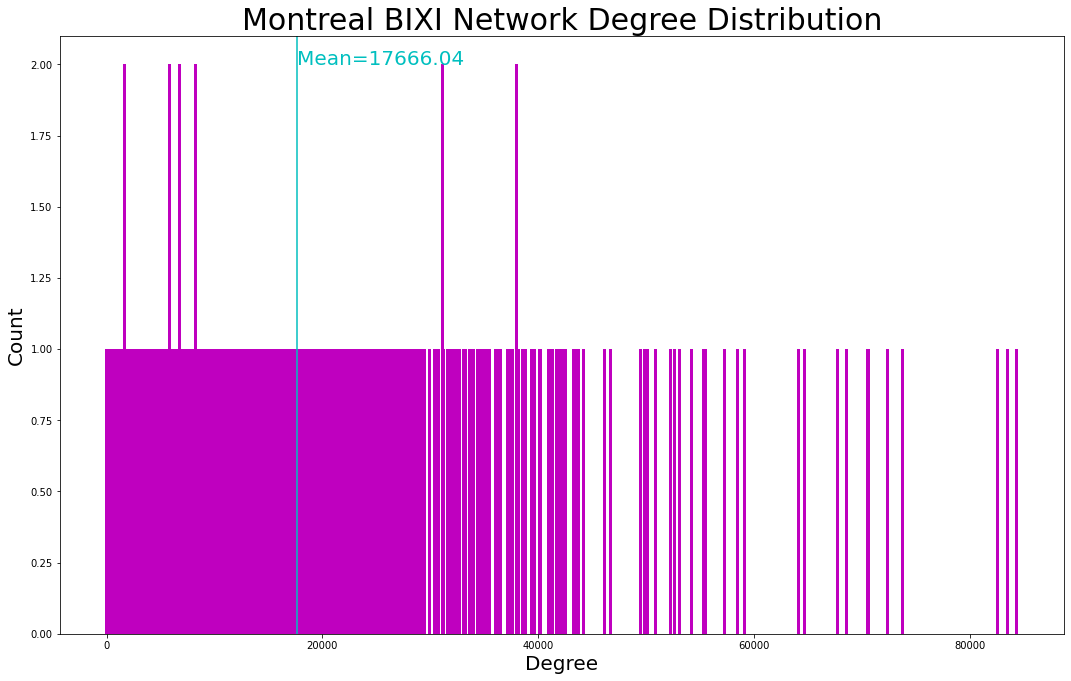

In [ ]:
degree_centrality_dist(SDG19)

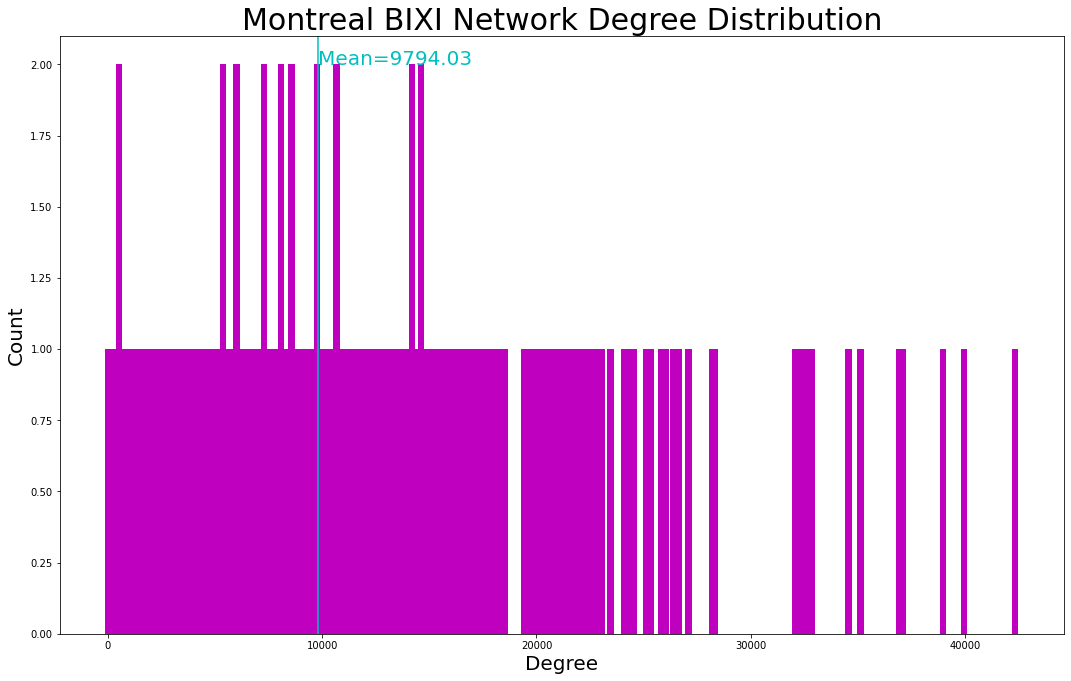

In [ ]:
degree_centrality_dist(SDG20)

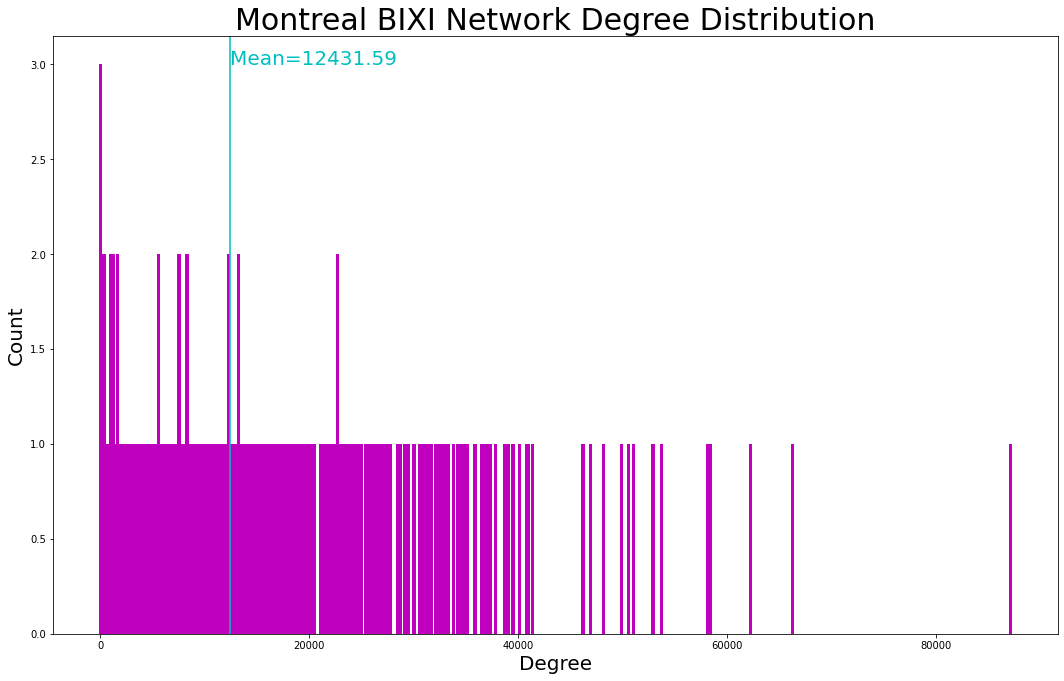

In [ ]:
degree_centrality_dist(SDG21)

In [ ]:
def shortest_path_dist(G):
    #Compute the shortest paths
    shortest_path=dict(nx.shortest_path_length(G))
    count_paths={}
    for k,v in shortest_path.items():
        count_paths=collections.Counter(list(v.values()))
    if not count_paths:
        return None
    
    fig, ax = plt.subplots(figsize=(18,11))
    ax.set_title("Montreal BIXI Network Shortest Paths Distribution", fontsize= 30)
    ax.set_xlabel("Degree", fontsize= 20)
    ax.set_ylabel("Count", fontsize= 20)
    #Use barplot to show the shortest paths distribution
    plt.bar(list(count_paths.keys()), list(count_paths.values()), width=1, color='m')
    #Add to the plot a vertical line representing the mean
    plt.axvline(x = np.mean(list(count_paths.keys())), color='c')    
    plt.text(x= np.mean(list(count_paths.keys())),y=max(list(count_paths.values()))+1, s="Mean={:.2f}".format(np.mean(list(count_paths.keys()))), color = 'c', fontsize= 20)
    
    #Save plot first
    fig.savefig("{}/plots/shortest_paths_dist.png".format(filepath_export), format="png")

    plt.show()

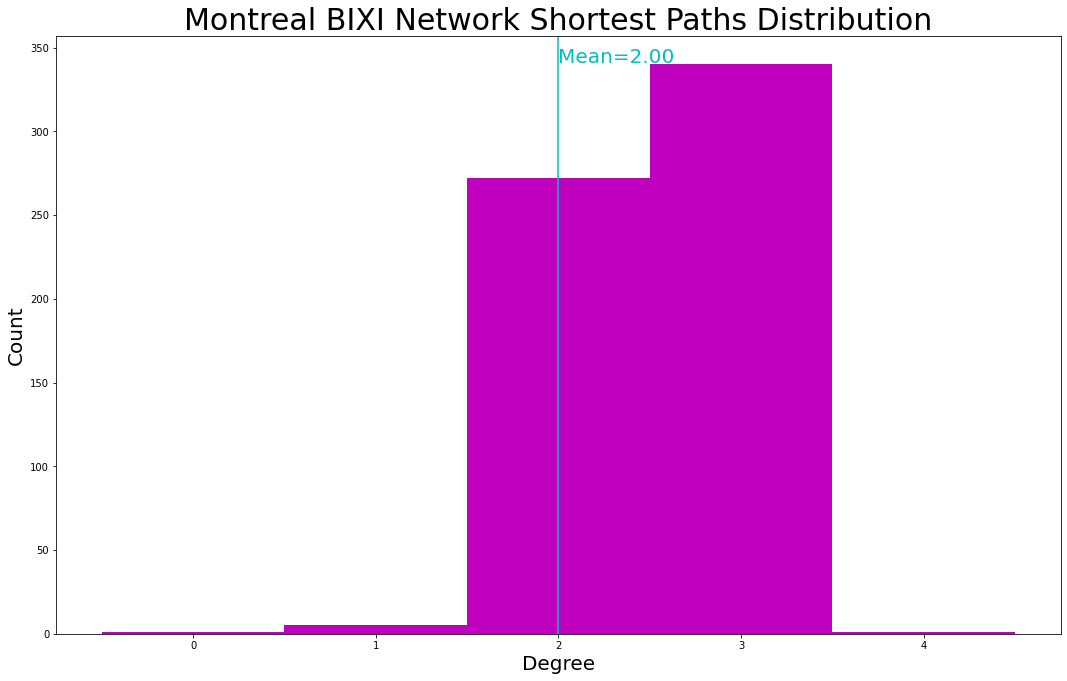

In [ ]:
shortest_path_dist(SDG19)

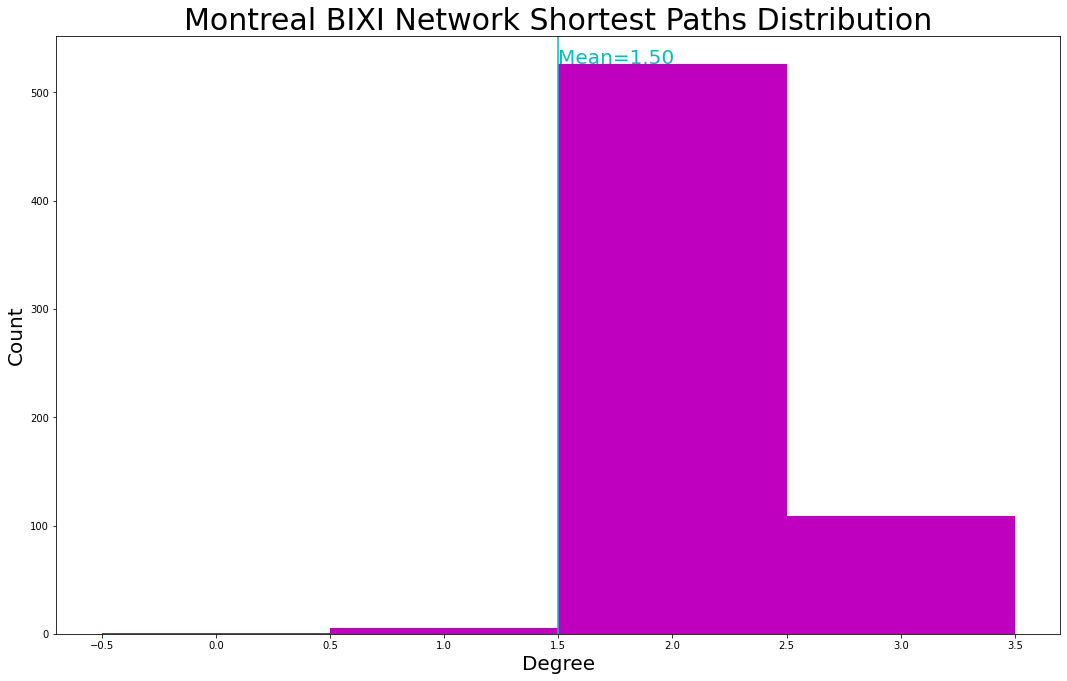

In [ ]:
shortest_path_dist(SDG20)

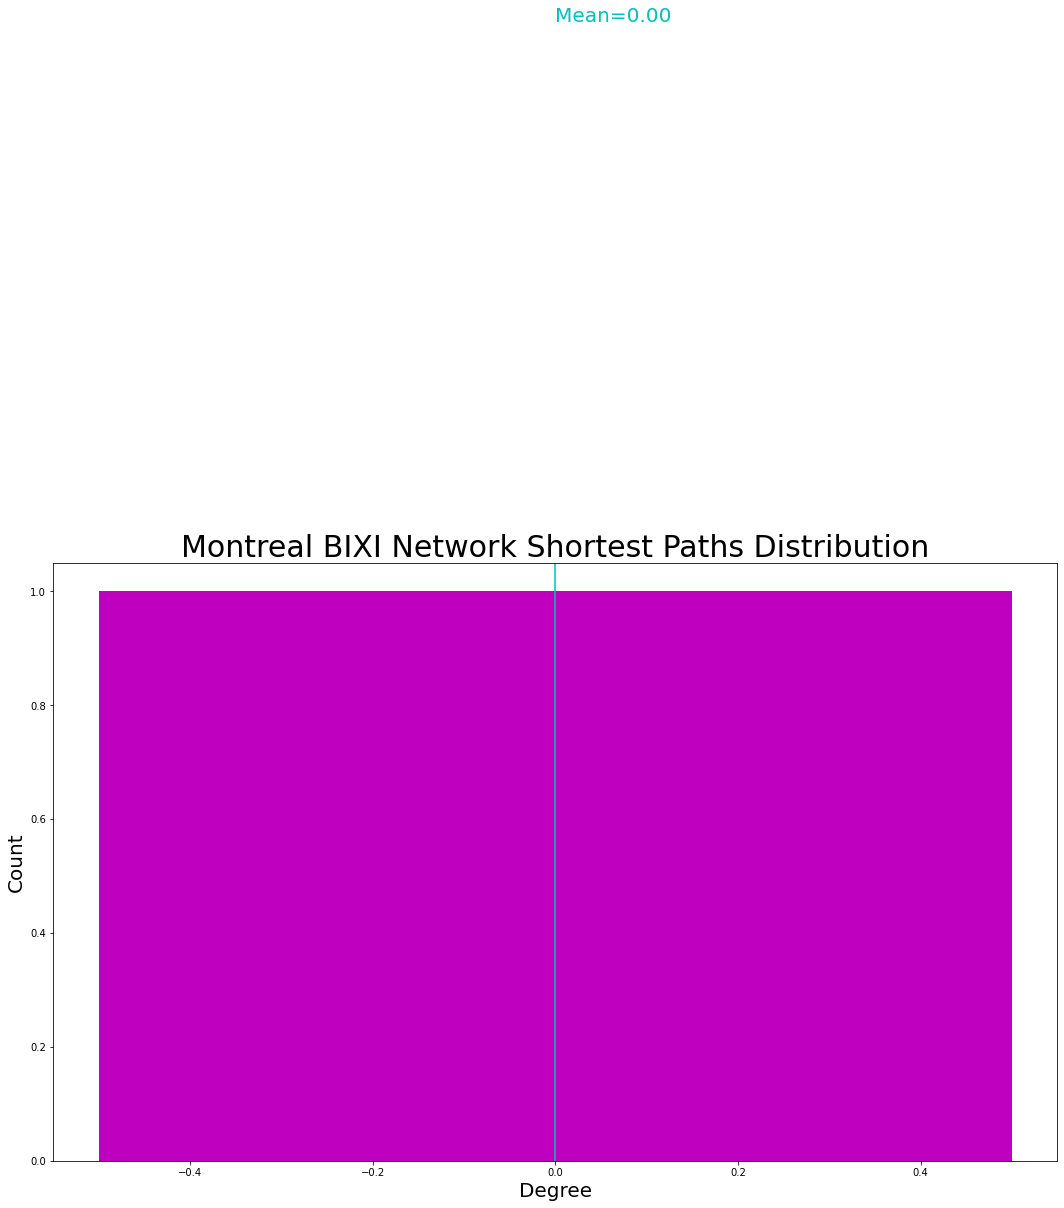

In [ ]:
shortest_path_dist(SDG21)

In [ ]:
#import mplleaflet
#import contextily as cx
#import cartopy.crs as ccrs
def community_louvain(G):
    #Get partition with Louvain
    partition = community.community_louvain.best_partition(G)    
    fig, ax = plt.subplots(figsize=(18,11))
    ax.set_title('Montreal BIXI Network Communities with Louvain Method', fontsize=20)
    cmap = cm.get_cmap('plasma', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, G.nodes.data('coord'), partition.keys(), node_size=50, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('coord'), edge_color='grey', alpha=0.05)
    #Remove axis
    ax.axis('off')
    
    #Save plot first
    fig.savefig("{}/plots/community_louvain.png".format(filepath_export), format="png")
    #cx.add_basemap(ax, crs=ccrs.PlateCarree(central_longitude=-73.561668, globe=None),source=cx.providers.OpenStreetMap.Mapnik)
    plt.show()
    #mplleaflet.display(fig)
    
    return partition

In [ ]:
def export_louvain_community_values(G, data, stations_names, yr):

    comm_nodes_augmented = {}
    for station_code,comm in data.items():
        comm_nodes_augmented[station_code] = [comm, stations_names[station_code], G.nodes[station_code]['coord'][0], G.nodes[station_code]['coord'][1]]

    with open(f"{filepath_export}/data/BixiMontrealRentals{yr}/Louvain_community_nodes.csv", 'w') as csv_file:  
        writer = csv.writer(csv_file)
        writer.writerow(['station_code', 'community', 'station_name', 'lat', 'lon'])
        for key, value in comm_nodes_augmented.items():
            writer.writerow([key, value[0], value[1], value[2], value[3]])

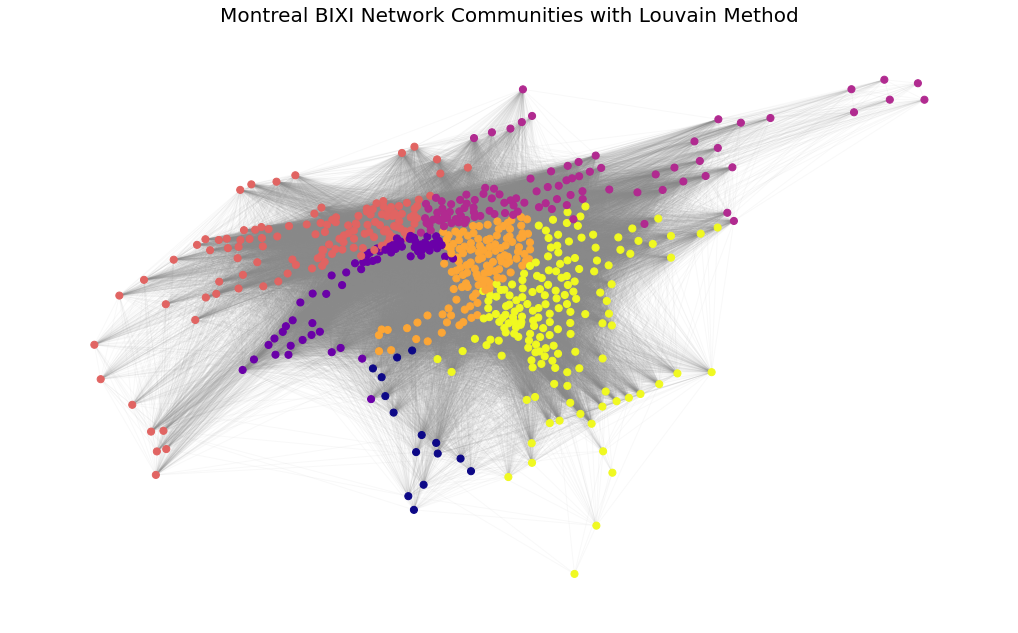

In [ ]:
comm_partition_louvain_19 = community_louvain(nx.Graph(SDG19))
export_louvain_community_values(SDG19, comm_partition_louvain_19, stations_names19, 2019)

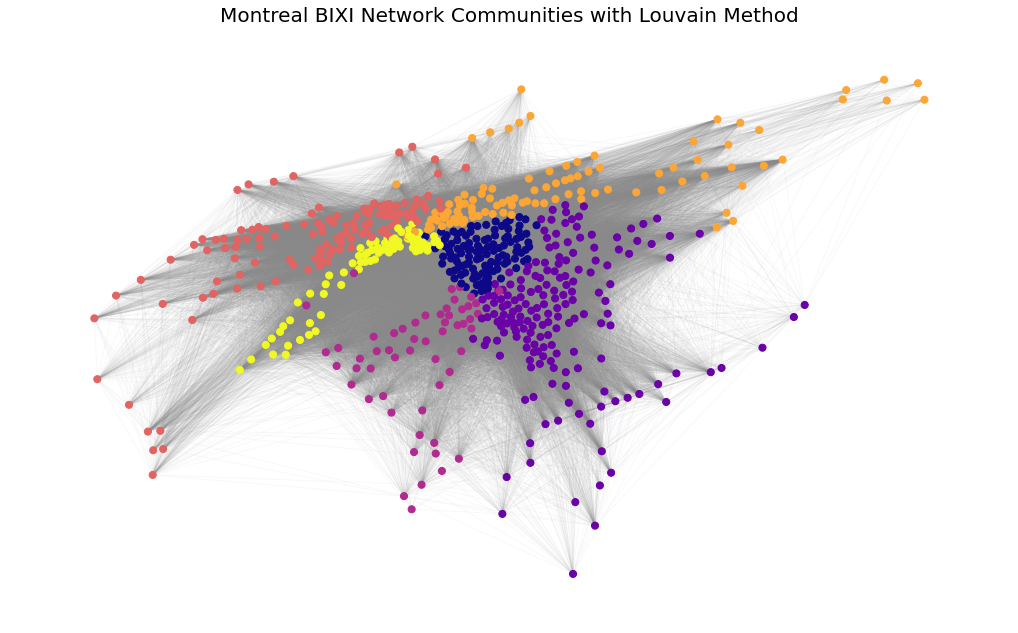

In [ ]:
comm_partition_louvain_20 = community_louvain(nx.Graph(SDG20))
export_louvain_community_values(SDG20, comm_partition_louvain_20, stations_names20, 2020)

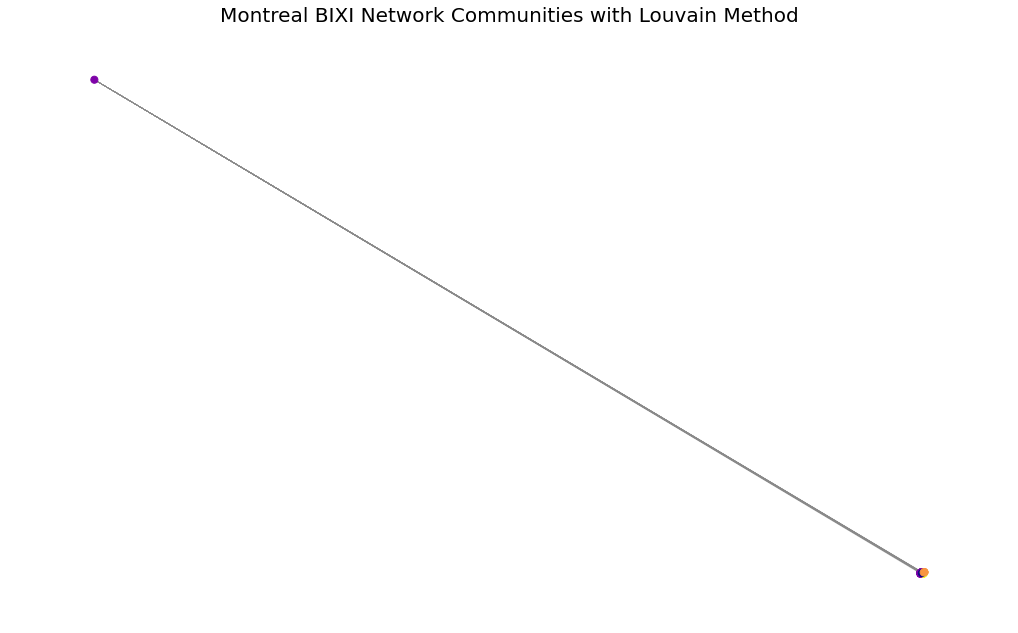

In [ ]:
comm_partition_louvain_21 = community_louvain(nx.Graph(SDG21))
#export_louvain_community_values(SDG21, comm_partition_louvain_21, stations_names21, 2021)

In [ ]:
def export_edges(G, stations_names, yr):
    edges = {}
    i = 0
    for start,end in G.edges:
        i += 1
        edges[i] = [start, stations_names[start], G.nodes[start]['coord'][0], G.nodes[start]['coord'][1], end, stations_names[end], G.nodes[end]['coord'][0], G.nodes[end]['coord'][1], G[start][end]['weight']]

    with open(f"{filepath_export}/data/BixiMontrealRentals{yr}/edgelist.csv", 'w') as csv_file:  
        writer = csv.writer(csv_file)
        #writer.writerow(['i', 'start_station_code', 'start_station_name', 'start_lat', 'start_lon', 'end_station_code', 'end_station_name', 'end_lat', 'end_lon', 'weight'])
        writer.writerow(['i', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'weight'])

        for key, value in edges.items():
            #writer.writerow([key, value[0], value[1], value[2], value[3], value[4], value[5], value[6], value[7], value[8]])
            writer.writerow([key, value[0], value[1], value[2], value[3], value[4]])

In [ ]:
#trip_edges_df = create_graph(df_concat_OD, df_concat_Stations, 2019, get_df_only=True)
#export_edges_from_df(trip_edges_df, df_concat_Stations, 2019)
trip_edges_df.to_csv(f"{filepath_export}/data/BixiMontrealRentals2019/edgelist_timed.csv")

KeyboardInterrupt: ignored

In [ ]:
def export_edges_from_df(trip_edges_df, stations_names, yr):
    with open(f"{filepath_export}/data/BixiMontrealRentals{yr}/edgelist_timed.csv", 'w') as csv_file:  
        writer = csv.writer(csv_file)
        #writer.writerow(['i', 'start_station_code', 'start_station_name', 'start_lat', 'start_lon', 'end_station_code', 'end_station_name', 'end_lat', 'end_lon', 'weight'])
        writer.writerow(['start_date', 'start_latitude', 'start_longitude', 'end_date', 'end_latitude', 'end_lon', 'duration_sec', 'is_member'])
        j=0
        for index, row in trip_edges_df.iterrows():
          print([row['start_date'], row['start_latitude'], row['start_longitude'], row['end_date'], row['end_latitude'], row['end_longitude'], row['duration_sec'], row['is_member']])
          writer.writerow([row['start_date'], row['start_latitude'], row['start_longitude'], row['end_date'], row['end_latitude'], row['end_longitude'], row['duration_sec'], row['is_member']])
          j+=1
          if j==5:
            break


In [ ]:
export_edges(SDG19, stations_names19, 2019)

In [ ]:
export_edges(SDG20, stations_names20, 2020)

In [ ]:
export_edges(SDG21, stations_names21, 2021)

In [ ]:
def fast_modularity(G):
    #Get partition with FastModularity
    partition = [list(item) for item in greedy_modularity_communities(G)]
    nodes_comm={}
    for i,item in enumerate(partition):
        for elt in item:
            nodes_comm[elt]=i
            
    fig, ax = plt.subplots(figsize=(18,11))
    ax.set_title('Montreal BIXI Network Communities with Fast Modularity Method', fontsize=20)
    cmap = cm.get_cmap('plasma', len(partition))
    nx.draw_networkx_nodes(G, G.nodes.data('coord'), nodes_comm.keys(), node_size=50, cmap=cmap, node_color=list(nodes_comm.values()))
    nx.draw_networkx_edges(G, G.nodes.data('coord'), edge_color='grey', alpha=0.05)
    #Remove axis
    ax.axis('off')
    
    #Save plot first
    fig.savefig("{}/plots/community_fast_modularity.png".format(filepath_export), format="png")
    
    plt.show()
    return partition

In [ ]:
def export_fastmod_community_values(G, data, stations_names, yr):

    comm_nodes_augmented = {}
    for comm in data:
        for station_code in comm:
            comm_nodes_augmented[station_code] = [comm, stations_names[station_code], G.nodes[station_code]['coord'][0], G.nodes[station_code]['coord'][1]]

    with open(f"{filepath_export}/data/BixiMontrealRentals{yr}/Fastmod_community_nodes.csv", 'w') as csv_file:  
        writer = csv.writer(csv_file)
        writer.writerow(['station_code', 'community', 'station_name', 'lat', 'lon'])
        for key, value in comm_nodes_augmented.items():
            writer.writerow([key, value[0], value[1], value[2], value[3]])

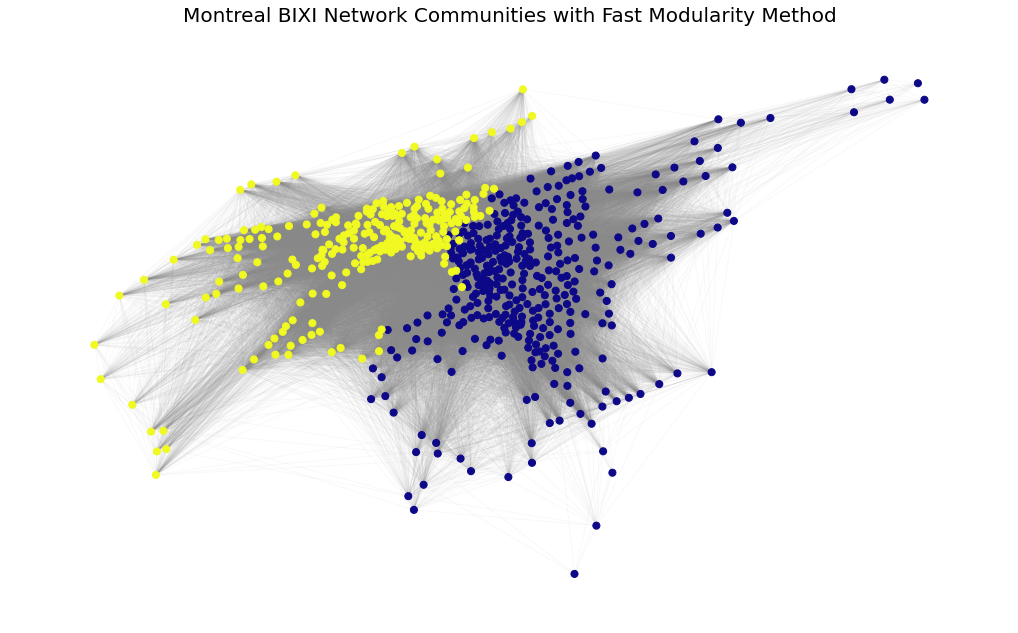

In [ ]:
comm_partition_fastmod_19 = fast_modularity(nx.Graph(SDG19))
export_fastmod_community_values(SDG19, comm_partition_fastmod_19, stations_names19, 2019)

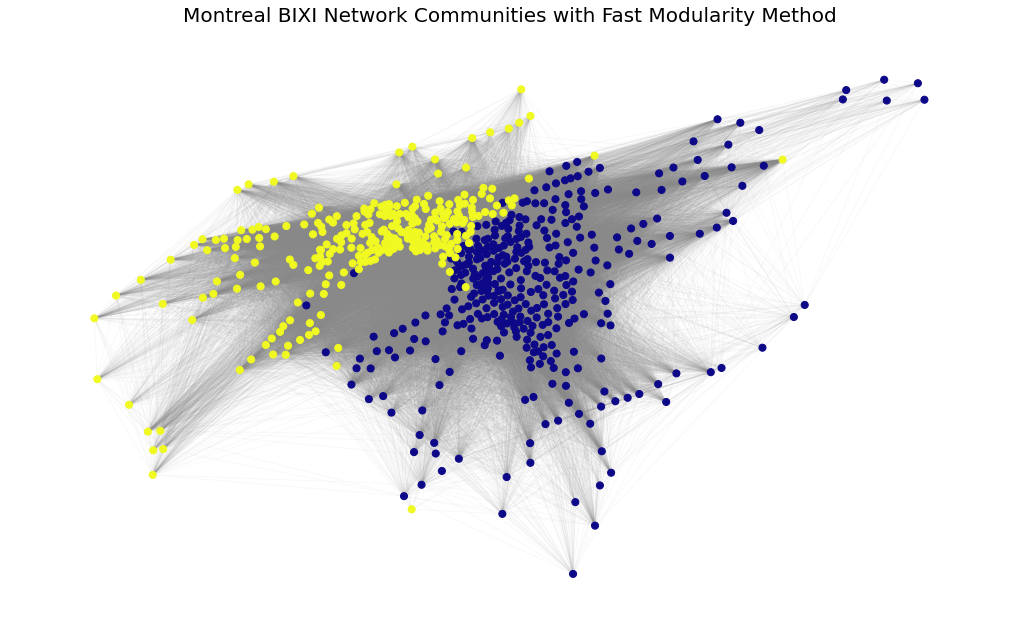

In [ ]:
comm_partition_fastmod_20 = fast_modularity(nx.Graph(SDG20))
export_fastmod_community_values(SDG20, comm_partition_fastmod_20, stations_names20, 2020)

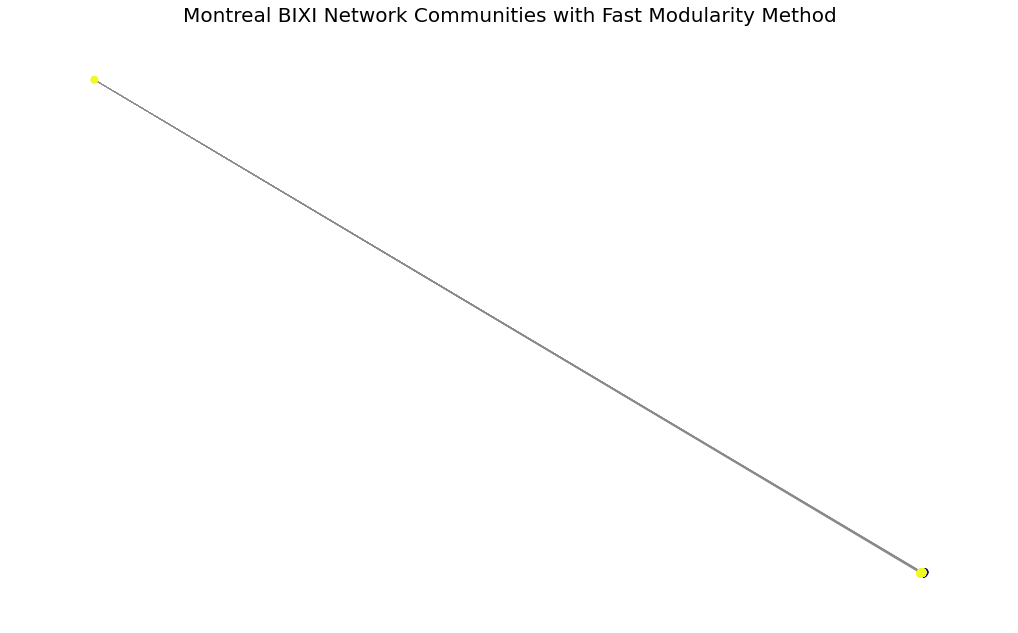

In [ ]:
comm_partition_fastmod_21 = fast_modularity(nx.Graph(SDG21))
export_fastmod_community_values(SDG21, comm_partition_fastmod_21, stations_names21, 2021)